# Chapter 07  금융공학 모델링

일별시세 페이지 분석

In [6]:
index_cd = 'KPI200'
page_n = 1
naver_index = 'http://finance.naver.com/sise/sise_index_day.nhn?code=' + index_cd + '&page=' + str(page_n)

In [7]:
from urllib.request import urlopen  
source = urlopen(naver_index).read()
#source


In [8]:
import bs4
source = bs4.BeautifulSoup(source, 'lxml')

In [9]:
td = source.find_all('td')
len(td)

54

날짜 추출

In [10]:
# /html/body/div/table[1]/tbody/tr[3]/td[1]
source.find_all('table')[0].find_all('tr')[2].find_all('td')[0]


<td class="date">2019.09.19</td>

In [11]:
from datetime import datetime, timedelta
import datetime as dt
pastday=source.find_all('td',class_='date')[5].text
today= source.find_all('td', class_='date')[0].text
print(today)
pastday=datetime.now()+timedelta(days=-365)
pastday=str(pastday.strftime('%Y.%m.%d'))
print(pastday)


2019.09.19
2018.09.19


In [12]:


yyyy,mm,dd = today.split('.')[0:3] 
#mm = int(today.split('.')[1])
#dd = int(today.split('.')[2])

this_date= dt.date(int(yyyy), int(mm), int(dd))
this_date

datetime.date(2019, 9, 19)

날짜정보를  date 타입으로 변경하는 함수 정의

In [13]:
def date_format(d):
    d = str(d).replace('-', '.')
    
    yyyy = int(d.split('.')[0]) 
    mm = int(d.split('.')[1])
    dd = int(d.split('.')[2])

    this_date= dt.date(yyyy, mm, dd)
    return this_date



종가 추출

In [14]:
this_close = source.find_all('tr')[2].find_all('td')[1].text
this_close = this_close.replace(',', '')
this_close = float(this_close)
this_close

274.33

In [15]:
p = source.find_all('td', class_='number_1')[0].text
p

'274.33'

페이지 상의 날짜와 종가정보 전체 추출

In [16]:
dates = source.find_all('td', class_='date')
dates
prices = source.find_all('td', class_='number_1')

In [17]:
len(dates)

6

In [18]:
len(prices)

24

In [19]:
for n in range(len(dates)):
    this_date = dates[n].text
    this_date = date_format(this_date)
    
    this_close = prices[n*4].text   
    # 0, 4, 8, ... 4의 배수로 돌아가는 가격 추출
    this_close = this_close.replace(',', '')
    this_close = float(this_close)
    this_close
    
    print(this_date, this_close)

2019-09-19 274.33
2019-09-18 273.06
2019-09-17 271.68
2019-09-16 272.02
2019-09-11 270.84
2019-09-10 268.76


마지막 페이지 번호 찾기

In [20]:
paging = source.find('td', class_='pgRR').find('a')['href']
paging

'/sise/sise_index_day.nhn?code=KPI200&page=565'

In [21]:
paging = paging.split('&')[1]
paging

'page=565'

In [22]:
paging = paging.split('=')[1]
paging

'565'

In [23]:
naver_index = 'http://finance.naver.com/sise/sise_index_day.nhn?code=' + index_cd + '&page=' + str(505)

source = urlopen(naver_index).read()
source = bs4.BeautifulSoup(source, 'lxml')

if source.find('td', class_='pgRR'):
    last_page = source.find('td', class_='pgRR').find('a')['href']
    last_page = last_page.split('&')[1]
    last_page = last_page.split('=')[1]
    last_page = int(last_page)

In [24]:
def historical_index_naver(index_cd, page_n=1, last_page=0):   
        
    naver_index = 'http://finance.naver.com/sise/sise_index_day.nhn?code=' + index_cd + '&page=' + str(page_n)
    
    source = urlopen(naver_index).read()   # 지정한 페이지에서 코드 읽기
    source = bs4.BeautifulSoup(source, 'lxml')   # 뷰티풀 스프로 태그별로 코드 분류
    
    dates = source.find_all('td', class_='date')   # <td class="date">태그에서 날짜 수집   
    prices = source.find_all('td', class_='number_1')   # <td class="number_1">태그에서 지수 수집
    
    for n in range(len(dates)):
    
        if dates[n].text.split('.')[0].isdigit():
            
            # 날짜 처리
            this_date = dates[n].text
            this_date= date_format(this_date)
            
            # 종가 처리
            this_close = prices[n*4].text   # prices 중 종가지수인 0,4,8,...번째 데이터 추출
            this_close = this_close.replace(',', '')
            this_close = float(this_close)

            # 딕셔너리에 저장
            historical_prices[this_date] = this_close
            
    # 페이지 네비게이션
    if last_page == 0:
        last_page = source.find('td', class_='pgRR').find('a')['href']
        # 마지막페이지 주소 추출
        last_page = last_page.split('&')[1]   # & 뒤의 page=506 부분 추출
        last_page = last_page.split('=')[1]   # = 뒤의 페이지번호만 추출
        last_page = int(last_page)   # 숫자형 변수로 변환
        
    # 다음 페이지 호출
    if page_n < last_page:   
        page_n = page_n + 1   
        historical_index_naver(index_cd, start_date, end_date, page_n, last_page)   
        
    return historical_prices  

네이버에서 일자별 인덱스를 추출하는 함수 정의

In [25]:
def historical_index_naver(index_cd, start_date='', end_date='', page_n=1, last_page=0):
    
    if start_date:   # start_date가 있으면
        start_date = date_format(start_date)   # date 포맷으로 변환
    else:    # 없으면
        start_date = dt.date.today()   # 오늘 날짜를 지정
    if end_date:   
        end_date = date_format(end_date)   
    else:   
        end_date = dt.date.today()  
        
        
    naver_index = 'http://finance.naver.com/sise/sise_index_day.nhn?code=' + index_cd + '&page=' + str(page_n)
    
    source = urlopen(naver_index).read()   # 지정한 페이지에서 코드 읽기
    source = bs4.BeautifulSoup(source, 'lxml')   # 뷰티풀 스프로 태그별로 코드 분류
    
    dates = source.find_all('td', class_='date')   # <td class="date">태그에서 날짜 수집   
    prices = source.find_all('td', class_='number_1')   # <td class="number_1">태그에서 지수 수집
    
    for n in range(len(dates)):
    
        if dates[n].text.split('.')[0].isdigit():
            
            # 날짜 처리
            this_date = dates[n].text
            this_date= date_format(this_date)
            
            if this_date <= end_date and this_date >= start_date:   
            # start_date와 end_date 사이에서 데이터 저장
                # 종가 처리
                this_close = prices[n*4].text   # prices 중 종가지수인 0,4,8,...번째 데이터 추출
                this_close = this_close.replace(',', '')
                this_close = float(this_close)

                # 딕셔너리에 저장
                historical_prices[this_date] = this_close
                
            elif this_date < start_date:   
            # start_date 이전이면 함수 종료
                return historical_prices              
            
    # 페이지 네비게이션
    if last_page == 0:
        last_page = source.find('td', class_='pgRR').find('a')['href']
        # 마지막페이지 주소 추출
        last_page = last_page.split('&')[1]   # & 뒤의 page=506 부분 추출
        last_page = last_page.split('=')[1]   # = 뒤의 페이지번호만 추출
        last_page = int(last_page)   # 숫자형 변수로 변환
        
    # 다음 페이지 호출
    if page_n < last_page:   
        page_n = page_n + 1   
        historical_index_naver(index_cd, start_date, end_date, page_n, last_page)   
        
    return historical_prices  

In [26]:
from pandas import DataFrame

index_cd = 'KPI200'
historical_prices = dict()
hostorical_prices=DataFrame()
historical_prices=historical_index_naver(index_cd, pastday, today)
#historical_prices


# 다음에서 해외지수 추출

##  Daum 해외금융정보 서비스 중단으로   Naver로 대체

In [27]:
import pandas as pd
from urllib.request import urlopen
import json   # 해외지수는 json 형태로 표출됨

In [28]:
symbol = 'NII@NI225'
page = 1

In [29]:
url = 'https://finance.naver.com/world/worldDayListJson.nhn?symbol='+symbol+'&fdtc=0&page='+str(page)
raw = urlopen(url)
data = json.load(raw)

In [30]:
data[0]

{'symb': 'NII@NI225',
 'xymd': '20190918',
 'open': 22014.65,
 'high': 22027.86,
 'low': 21942.03,
 'clos': 21960.71,
 'diff': -40.61,
 'rate': -0.18,
 'gvol': 69398200}

In [31]:
data[0]['symb']

'NII@NI225'

In [32]:
len(data)

9

In [33]:
d = dict()
for n in range(len(data)):
    date = pd.to_datetime(data[n]['xymd']).date()
    price = float(data[n]['clos'])
    d[date] = price
print(d)

{datetime.date(2019, 9, 18): 21960.71, datetime.date(2019, 9, 17): 22001.32, datetime.date(2019, 9, 13): 21988.29, datetime.date(2019, 9, 12): 21759.61, datetime.date(2019, 9, 11): 21597.76, datetime.date(2019, 9, 10): 21392.1, datetime.date(2019, 9, 9): 21318.42, datetime.date(2019, 9, 6): 21199.57, datetime.date(2019, 9, 5): 21085.94}


In [34]:
def read_json(d, symbol, page=1):
    url = 'https://finance.naver.com/world/worldDayListJson.nhn?symbol='+symbol+'&fdtc=0&page='+str(page)
    raw = urlopen(url)
    data = json.load(raw)
    
    for n in range(len(data)):
        date = pd.to_datetime(data[n]['xymd']).date()
        price = float(data[n]['clos'])
        d[date] = price
        
    if len(data) == 10 and page<3:
        page += 1
        read_json(d, symbol, page)
        
    return (d)

In [35]:
historical_index = pd.Series()
historical_index = read_json(historical_index, symbol, page)

In [36]:
historical_index.head(3)

2019-09-18    21960.71
2019-09-17    22001.32
2019-09-13    21988.29
dtype: float64

In [37]:
indices = {
    'SPI@SPX' : 'S&P 500', 
    'NAS@NDX' : 'Nasdaq 100', 
    'NII@NI225' : 'Nikkei 225'
}

In [38]:
historical_indices = dict()
for key, value in indices.items(): 
    print (key, value)
    s = dict()
    s = read_json(s, key, 1)
    historical_indices[value] = s    
prices_df = pd.DataFrame(historical_indices)

SPI@SPX S&P 500
NAS@NDX Nasdaq 100
NII@NI225 Nikkei 225


In [39]:
prices_df.tail(3)

,S&P 500,Nasdaq 100,Nikkei 225
2019-09-16,2997.96,7852.41,NaN
2019-09-17,3005.70,7888.79,22001.32
2019-09-18,3006.73,7888.56,21960.71


In [40]:
def date_format(d=''):
    if d != '':
        this_date = pd.to_datetime(d).date()
    else:
        this_date = pd.Timestamp.today().date()   # 오늘 날짜를 지정
    return (this_date)

In [41]:
def index_global(d, symbol, start_date='', end_date='', page=1):

    end_date = date_format(end_date)
    if start_date == '':
        start_date = end_date - pd.DateOffset(months=1)
    start_date = date_format(start_date)
        
    url = 'https://finance.naver.com/world/worldDayListJson.nhn?symbol='+symbol+'&fdtc=0&page='+str(page)
    raw = urlopen(url)
    data = json.load(raw)
    
    if len(data) > 0:
        
        for n in range(len(data)):
            date = pd.to_datetime(data[n]['xymd']).date()

            if date <= end_date and date >= start_date:   
            # start_date와 end_date 사이에서 데이터 저장
                # 종가 처리
                price = float(data[n]['clos'])
                # 딕셔너리에 저장
                d[date] = price
            elif date < start_date:   
            # start_date 이전이면 함수 종료
                return (d)              

        if len(data) == 10:
            page += 1
            index_global(d, symbol, start_date, end_date, page)
        
    return (d)

In [42]:
historical_indices = dict()
start_date =pastday
end_date =today
for key, value in indices.items(): 
    s = dict()
    s = index_global(s, key, start_date)
    historical_indices[value] = s    
prices_df = pd.DataFrame(historical_indices)

In [43]:
prices_df.head(5)
print('')
prices_df.tail(5)

,S&P 500,Nasdaq 100,Nikkei 225
2019-09-12,3009.57,7917.34,21759.61
2019-09-13,3007.39,7892.95,21988.29
2019-09-16,2997.96,7852.41,NaN
2019-09-17,3005.70,7888.79,22001.32
2019-09-18,3006.73,7888.56,21960.71


# 만들어둔 함수를 이용해 KOSPI200과 S&P500 지수 추출

In [44]:
index_cd = 'KPI200'
historical_prices = dict()
kospi200 = historical_index_naver(index_cd, pastday, today)

In [45]:
index_cd = 'SPI@SPX'
historical_prices = dict()
sp500 = index_global(historical_prices, index_cd, pastday, today)    # 대체 코드
# sp500 = historical_global_daum(index_cd, '2017-1-1', '2017-12-31')    # 이전 코드

In [46]:
tmp = {'S&P500':sp500, 'KOSPI200':kospi200}

In [47]:
import pandas as pd

In [48]:
df = pd.DataFrame(tmp)
print(df.head())
print('.........')
print(df.tail())

             S&P500  KOSPI200
2018-09-19  2907.95    296.64
2018-09-20  2930.75    299.04
2018-09-21  2929.67    300.81
2018-09-24  2919.37       NaN
2018-09-25  2915.56       NaN
.........
             S&P500  KOSPI200
2019-09-13  3007.39       NaN
2019-09-16  2997.96    272.02
2019-09-17  3005.70    271.68
2019-09-18  3006.73    273.06
2019-09-19      NaN    274.33


In [49]:
df = df.fillna(method='ffill')
if df.isnull().values.any():
    df = df.fillna(method='bfill')
print(df.head())
print('.........')
print(df.tail())

             S&P500  KOSPI200
2018-09-19  2907.95    296.64
2018-09-20  2930.75    299.04
2018-09-21  2929.67    300.81
2018-09-24  2919.37    300.81
2018-09-25  2915.56    300.81
.........
             S&P500  KOSPI200
2019-09-13  3007.39    270.84
2019-09-16  2997.96    272.02
2019-09-17  3005.70    271.68
2019-09-18  3006.73    273.06
2019-09-19  3006.73    274.33


In [50]:
index_cd = 'KPI200'
historical_prices = dict()
kospi200 = historical_index_naver(index_cd, pastday, today)

In [51]:
tmp = {'S&P500':sp500, 'KOSPI200':kospi200}

In [52]:
df = pd.DataFrame(tmp)
print(df.head())
print('..........')
print(df.tail())

             S&P500  KOSPI200
2018-09-19  2907.95    296.64
2018-09-20  2930.75    299.04
2018-09-21  2929.67    300.81
2018-09-24  2919.37       NaN
2018-09-25  2915.56       NaN
..........
             S&P500  KOSPI200
2019-09-13  3007.39       NaN
2019-09-16  2997.96    272.02
2019-09-17  3005.70    271.68
2019-09-18  3006.73    273.06
2019-09-19      NaN    274.19


In [53]:
df = df.fillna(method='ffill')
if df.isnull().values.any():
    df = df.fillna(method='bfill')
print(df.head())
print('........')
print(df.tail())

             S&P500  KOSPI200
2018-09-19  2907.95    296.64
2018-09-20  2930.75    299.04
2018-09-21  2929.67    300.81
2018-09-24  2919.37    300.81
2018-09-25  2915.56    300.81
........
             S&P500  KOSPI200
2019-09-13  3007.39    270.84
2019-09-16  2997.96    272.02
2019-09-17  3005.70    271.68
2019-09-18  3006.73    273.06
2019-09-19  3006.73    274.19


# matplotlib를 이용해 그래프 그리기

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

No handles with labels found to put in legend.


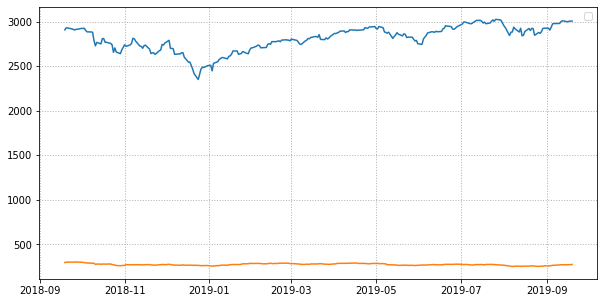

In [170]:
plt.figure(facecolor='w', figsize=(10, 5))
plt.plot(df['S&P500'])
plt.plot(df['KOSPI200'])
plt.legend(loc=0)
plt.grid(True, color='0.7', linestyle=':', linewidth=1)

In [56]:
df.iloc[0]

S&P500      2907.95
KOSPI200     296.64
Name: 2018-09-19, dtype: float64

In [138]:
y,m,d=pastday.split('.')[0:3]
#m=pastday.split('.')[1]
#d=pastday.split('.')[2]
y=int(y); m=int(m);  d=int(d);
df.loc[dt.date(y,m,d) ]

9


S&P500      2907.95
KOSPI200     296.64
Name: 2018-09-19, dtype: float64

No handles with labels found to put in legend.


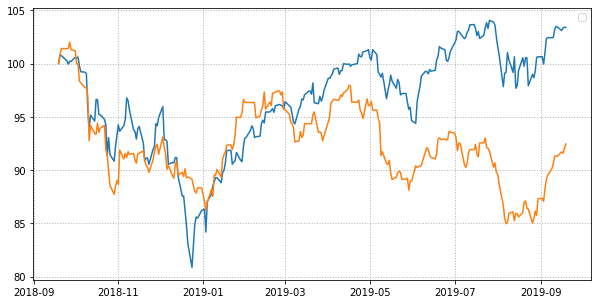

In [71]:
plt.figure(figsize=(10, 5))
plt.plot(df['S&P500'] / df['S&P500'].loc[dt.date(y,m,d)] * 100)
plt.plot(df['KOSPI200'] / df['KOSPI200'].loc[dt.date(y,m,d)] * 100)
plt.legend(loc=0)
plt.grid(True, color='0.7', linestyle=':', linewidth=1)

In [165]:
pday1=datetime.now()+timedelta(-30)
pday1=str(pday1.strftime('%Y.%m.%d'))
py1,pm1,pd1=pday1.split('.')[0:3]
py1=int(py1); pm1=int(pm1); pd1=int(pd1);
pday3=datetime.now()+timedelta(-34)
pday3=str(pday3.strftime('%Y.%m.%d'))
py3,pm3,pd3=pday3.split('.')[0:3]
py3=int(py3); pm3=int(pm3); pd3=int(pd3);
df_ratio_now = df.loc[dt.date(py3,pm3,pd1):] / df.loc[dt.date( py1,pm1,pd1)] * 100
df_ratio_now.head(4)

,S&P500,KOSPI200
2019-08-20,100.000000,100.000000
2019-08-21,100.824683,100.127882
2019-08-22,100.773657,99.314086
2019-08-23,98.158944,99.248208


No handles with labels found to put in legend.


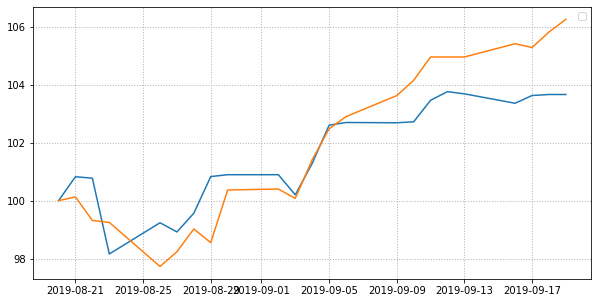

In [166]:
plt.figure(figsize=(10, 5))
plt.plot(df_ratio_now['S&P500'])
plt.plot(df_ratio_now['KOSPI200'])
plt.legend(loc=0)
plt.grid(True, color='0.7', linestyle=':', linewidth=1)

Text(0, 0.5, 'KOSPI200')

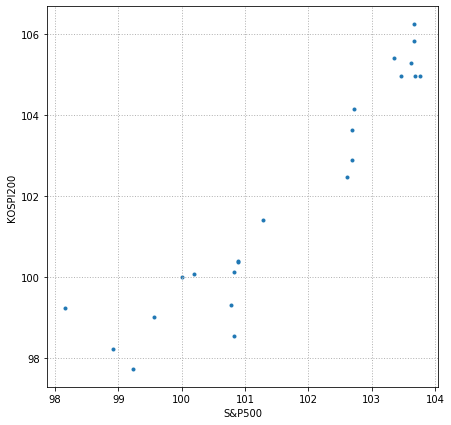

In [167]:
plt.figure(figsize=(7,7))
plt.scatter(df_ratio_now['S&P500'], df_ratio_now['KOSPI200'], marker='.')
plt.grid(True, color='0.7', linestyle=':', linewidth=1)
plt.xlabel('S&P500')
plt.ylabel('KOSPI200')

In [168]:
import numpy as np
from sklearn.linear_model import LinearRegression

x = df_ratio_now['S&P500']
y = df_ratio_now['KOSPI200']

# 1개 컬럼 np.array로 변환
independent_var = np.array(x).reshape(-1, 1)
dependent_var = np.array(y).reshape(-1, 1)

# Linear Regression
regr = LinearRegression()
regr.fit(independent_var, dependent_var)

result = {'Slope':regr.coef_[0,0], 'Intercept':regr.intercept_[0], 'R^2':regr.score(independent_var, dependent_var) }
result

{'Slope': 1.4975373748139036,
 'Intercept': -50.227434658985004,
 'R^2': 0.8883822136284631}

Text(0, 0.5, 'KOSPI200')

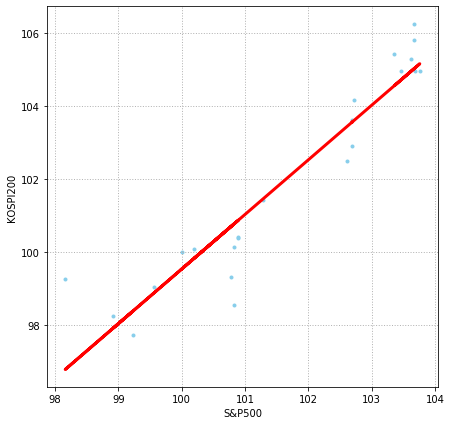

In [169]:
plt.figure(figsize=(7,7))
plt.scatter(independent_var, dependent_var, marker='.', color='skyblue')
plt.plot(independent_var, regr.predict(independent_var), color='r', linewidth=3)
plt.grid(True, color='0.7', linestyle=':', linewidth=1)
plt.xlabel('S&P500')
plt.ylabel('KOSPI200')